# 1. Euler angle을 누적한 자세 추정

- 가장 단순한 형태의 자세 추정
- gyroscope의 출력($p, q, r$)을 Euler Angular rate($\dot \phi, \dot \theta, \dot \psi)$로 변환하고 변환된 Euler angular rate를 누적 하여 Euler angle($\hat \phi, \hat \theta,\hat \psi$)를 구한다.
- 시간에 따른 gyroscope의 에러가 누적되는 단점이 있다.
- Gyroscope 출력을 Euler angular rate로 변환하는 것은 다음과 같다.
- 여기서 $z_t$는 measurement를 의미하며 Euler Angle의 변화가 measurement가 된다.

$$
z_{t}=
\begin{bmatrix}
\dot \phi\\
\dot \theta\\
\dot \psi\\
\end{bmatrix}
=
\begin{bmatrix}
1&\sin \phi \tan \theta& \cos \phi \tan \ \theta\\
0& \cos\phi& -\sin\phi\\
0&\sin\phi/\cos\theta&\cos\phi/cos\theta
\end{bmatrix}
\begin{bmatrix}
p\\
q\\
r\\
\end{bmatrix}
$$

- Euler angle을 누적하는 것은 매 sample 주기 마다 수행되며 이전의 Euler angle($\hat \phi_{t-1}, \hat \theta_{t-1}, \hat \psi_{t-1}$)추정 값에 새로 업데이트된 $T_s\times z_t $값을 더하는 것으로 계산된다.

$$
\begin{aligned}
\hat \phi_t &=
{\left(  \hat \phi_{t-1} + T_s z_{t, \dot \phi} \right)}\\
\hat \theta_t &= 
{\left(\hat \theta_{t-1} + T_s z_{t, \dot \theta} \right)}\\
\hat \psi_t &=
{\left(\hat \psi_{t-1} + T_s z_{t, \dot \psi} \right)}
\end{aligned}\\
$$

- 누적에 의한 자세 추정을 간단하게 표시하면,

$$
\begin{aligned}
\theta_1 &= \theta_0 +(\omega_0+\eta_0)T_s\\
&= \theta_0 +\omega_0T_s+\eta_0T_s
\end{aligned}
$$

- 여기서 $\omega_0$는 순수한 angular rate이며 $\eta_0$는 gyroscope의 noise이며 $\eta_0\sim\mathcal N(0, \sigma^2)$이다.
- 따라서 $\eta_0T_s$는 다음과 같이 평균이 0이고 분산이 $\sigma^2T_s^2$인 normal distribution의 특성을 갖는다.
$$
\eta_0 T_s\sim\mathcal N(0, \sigma^2T_s^2)
$$
- Recursive하게 integration을 반복하게 되면, 

$$
\begin{aligned}
\theta_2 &= \theta_1 +(\omega_1+\eta_1)T_s\\
         &= \theta_0 +\omega_0T_s+\eta_0T_s + \omega_1T_s+\eta_1T_s\\
         &= \theta_0 +(\omega_0+\omega_1)T_s+(\eta_0+\eta_1)T_s 
\end{aligned}
$$

- 여기서 노이즈는 $(\eta_0+\eta_1)T_s\sim \mathcal N(0, 2\sigma^2T_s^2)$가 된다.
- 이렇게 되는 이유는 $var(\eta_0+\eta_1)=var(\eta_0)+var(\eta_1)+2cov(\eta_1, \eta_2)$인데, noise의 경우 $cov(\eta_1, \eta_2)=0$의 성질을 가지기 때문이다.
- 위의 누적식을 일반화 해보면,

$$
\theta_n = \theta_0 + \left(\sum_{i=0}^{n-1} \omega_i \right)T_s + \left(\sum_{i=0}^{n-1} \eta_i \right)T_s 
$$

- 여기서 첫 번째항은 초기 자세정보, 두 번째 항은 agular rate의 누적분, 그리고 세 번째 항이 noise항이다.
- noise항의 정규분포는

$$
\left(\sum_{i=0}^{n-1} \omega_i \right)T_s \sim \mathcal N(0, n\sigma^2T_s^2)
$$

- Agular rate를 누적하여 자세를 추정하게 되면 gyroscope에서 기인하는 noise가 누적되게 된다.
- 이것은 시간이 지남에 따라 자세추정 오차가 $\pm 3\sigma$내에 존재하게 된다.

# 2. Program

In [1]:
import numpy as np
from scipy.io import loadmat
from math import sin, cos, tan
import matplotlib.pyplot as plt
from navimath import *


In [2]:
# Dataset selection
# f_number 
# 1: Example data provided by Magdwich
# 2: Real IMU data provided by Witmotion 
# 3: Real IMU data provided by Understanding Kalman filter
f_number = 1


if f_number == 1:
    # Example Data
    ExData1 = loadmat('..\Data\ExampleData.mat')
    Gyroscope = np.deg2rad(ExData1['Gyroscope'])
    Accelerometer = ExData1['Accelerometer']
    Magnetometer = ExData1['Magnetometer']
    time = ExData1['time']
    
    # System model noise covariance
    Q = np.zeros((3,3))
    Q[0, 0] = 0.01     # Roll angle uncertainty
    Q[1, 1] = 0.01     # Pitch angle uncertainty
    Q[2, 2] = 1     # Yaw angle uncertainity    

    # Measurement noise covariance
    R = np.zeros((3,3))
    R[0, 0] = 10      # Accelerometer measurement uncertainty
    R[1, 1] = 10      # Accelerometer measurement uncertainty
    R[2, 2] = 10     # Magnetometer measurement uncertainity    
    
    mu0 = np.zeros((3))
    sigma0 = np.eye((3))
    
    Ts = time[1]-time[0]
    totalLen = Accelerometer.shape[0]
    
elif f_number ==2:

    # Example Data
    ExData1 = loadmat('..\Data\WitMotion_IMU_Data.mat')
    Gyroscope = np.deg2rad(ExData1['Gyroscope'])
    Accelerometer = ExData1['Accelerometer']
    Magnetometer = ExData1['Magnetometer']
    Euler_Truth = ExData1['Euler']
        
    # System model noise covariance
    Q = np.zeros((3,3))
    Q[0, 0] = 100     # Roll angle uncertainty
    Q[1, 1] = 100     # Pitch angle uncertainty
    Q[2, 2] = 1000     # Yaw angle uncertainity

    # Measurement noise covariance
    R = np.zeros((3,3))
    R[0, 0] = 10      # Accelerometer measurement uncertainty
    R[1, 1] = 10      # Accelerometer measurement uncertainty
    R[2, 2] = 10     # Magnetometer measurement uncertainity
    
    mu0 = np.zeros((3))
    sigma0 = np.eye((3))
    
    Ts = 1
    totalLen = Accelerometer.shape[0]
    
else:
    ArsAccel = loadmat('..\Data\ArsAccel.mat')
    ArsGyro = loadmat('..\Data\ArsGyro.mat')
    
    Gyroscope = np.zeros((41500, 3))
    Accelerometer = np.zeros((41500, 3))
    
    Gyroscope[:,0] = ArsGyro['wx'][:,0]
    Gyroscope[:,1] = ArsGyro['wy'][:,0]
    Gyroscope[:,2] = ArsGyro['wz'][:,0]
    
    Accelerometer[:,0] = ArsAccel['fx'][:,0]
    Accelerometer[:,1] = ArsAccel['fy'][:,0]
    Accelerometer[:,2] = ArsAccel['fz'][:,0]    
    
    Q = np.array([[0.0001, 0, 0],
              [0, 0.0001, 0],
              [0, 0, 1]])
    R = 10 * np.eye(3)
    
    mu0 = np.zeros((3))
    sigma0 = np.eye((3))
    
    Ts = 0.01
    totalLen = 41500

In [3]:
n_x = 3

# Sensor fusion 결과 확인을 위한 보조 변수들 
attitude = np.zeros((n_x))
attitude_hist = np.zeros((totalLen, 3))

# measurement update에 사용되는 measurement를 위한 변수
z_hist = np.zeros((totalLen, 3))

for i in range(totalLen):
    
    # initialization
    if i == 0:                
        attitude = mu0
    
    attitude = Euler_accum(attitude, Gyroscope[i,:], Ts)    
    attitude_hist[i,:] = attitude
    
    # Measurement update를 위한 Accelerometer와 Magnetometer를 사용한 Attitude
    if f_number == 3:
        z = attitudemeasure(attitude, 1, Accelerometer[i,:])
    else:
        z = attitudemeasure(attitude, 2, Accelerometer[i,:], Magnetometer[i,:])   
        
    z_hist[i,:] = z
    
    

Text(0.5, 1.0, 'Attitude by accelerometer and magnetometer')

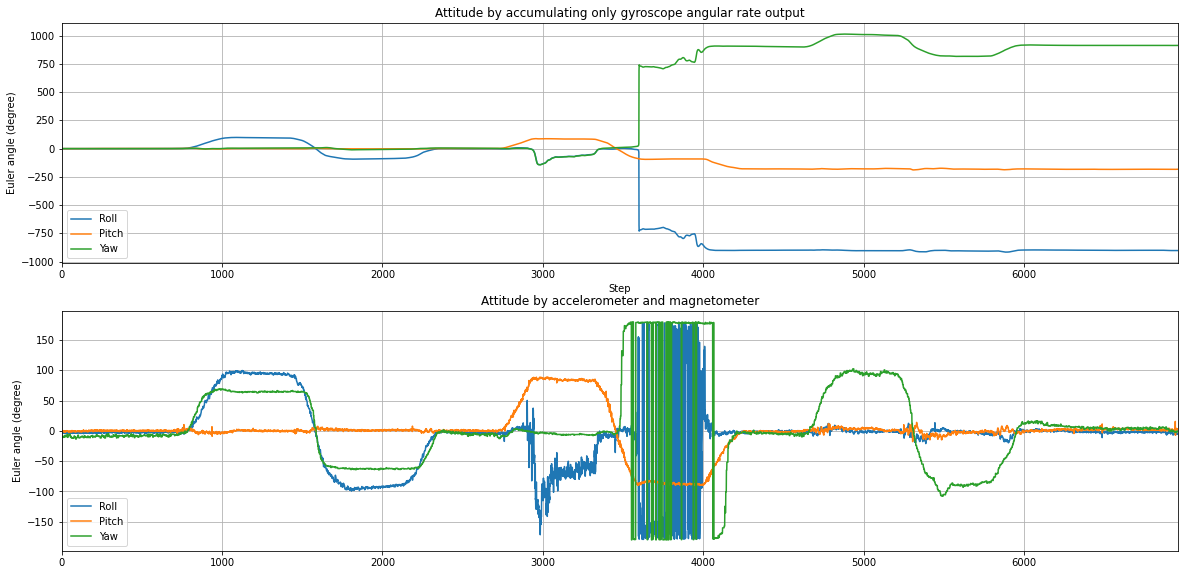

In [4]:
plt.figure(figsize=(20,15))

# Result plotting
plt.subplot(3,1,2)    
plt.plot(np.rad2deg(attitude_hist))
plt.legend(['Roll','Pitch','Yaw'], loc = 'lower left')
plt.grid()
plt.xlabel('Step')
plt.ylabel('Euler angle (degree)')
plt.xlim([0,totalLen])
plt.title('Attitude by accumulating only gyroscope angular rate output')

if f_number == 3:
    title = 'Attitude by accelerometer'    
else:
    title = 'Attitude by accelerometer and magnetometer'
    
    
# Measurement updat를 위한 accelerometer와 magnatometer의 자세
plt.subplot(3,1,3)    
plt.plot(np.rad2deg(z_hist))
#plt.plot(z_hist)
plt.legend(['Roll','Pitch','Yaw'], loc = 'lower left')
plt.grid()
plt.ylabel('Euler angle (degree)')
plt.xlim([0,totalLen])
plt.title(title)
